In [58]:
import os
import gym
import math
import random
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

%matplotlib inline

In [54]:
# matplotlib 셋업
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU가 쓰인다면?
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Replay Memory

DQN을 학슴하기위해 replay memory를 사용하려한다. 
이건 에이전트가 관찰한 transition을 저장하고 추후 재사용 가능하다.

랜덤하게 샘플링해서 추출되므로, transition은 상호관계가 없다.

이를 위해선 두 클래스가 필요하다.
* ```Transition``` - 환경에서 싱글 transition named tuple
* ```ReplayMemory``` - 순환 버퍼 

In [34]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        # saves a transition
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [35]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

C:\Users\RRBB\Anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


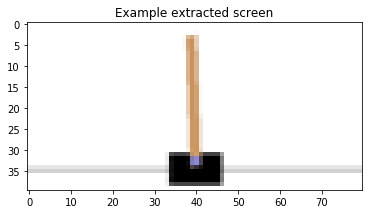

In [36]:
resize = T.Compose([T.ToPILImage(),
                    T.Scale(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [37]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])

    
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001) # 잠시 멈추고 업데이트
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [38]:
last_sync = 0

def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state if s is not None]), volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    
    # Q(s_t, a)를 계산. 
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # V(s_{t+1}을 계산)
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    # loss를 망치지않기 위해 volatile을 바꾸기
    next_state_values.volatile = False
    # expected Q-value를 구함
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Huber Loss 를 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # optimize
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

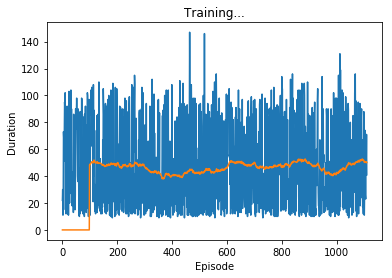

In [ ]:
env = gym.make('CartPole-v0').unwrapped

model_saved_dir = './tmp/model.pickle'
durations_saved_dir = './tmp/durations.pickle'
if os.path.exists(model_saved_dir):
    model = torch.load(model_saved_dir)
    print('Loading Model')
else:
    model = DQN()

if os.path.exists(durations_saved_dir):
    with open(durations_saved_dir, 'rb') as f:
        episode_durations = pickle.load(f)
    print('Loading Episodes durations')
else:
    episode_durations = []

    
num_episodes = 1000
    
for i_episode in range(num_episodes):
    # 환경과 상태를 초기화
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        # 액션을 선택 및 수행
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])
        
        # 새로운 상태를 관찰
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # 메모리에 전환 저장
        memory.push(state, action, next_state, reward)
        
        # 다음 상태로 이동
        state = next_state
        
        # 최적화 한스텝 수행
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            if t+1 >= max(episode_durations) or i_episode % 500 == 0:
                torch.save(model, './tmp/model.pickle')
                print('save model')
            with open(durations_saved_dir, 'wb') as f:
                pickle.dump(episode_durations, f)
            break
            
print('Complete')
env.close()
plt.ioff()
plt.show()
